## pseudo label

In [3]:
# to register
from pt.modeling.meta_arch.rcnn import GuassianGeneralizedRCNN
from pt.modeling.proposal_generator.rpn import GuassianRPN
from pt.modeling.roi_heads.roi_heads import GuassianROIHead
import pt.data.datasets.builtin
from pt.modeling.backbone.vgg import build_vgg_backbone
from pt.modeling.anchor_generator import DifferentiableAnchorGenerator
from pt.modeling.meta_arch.ts_ensemble import EnsembleTSModel

import torch


/home/superorange5/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py:803: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [4]:
from detectron2.config import get_cfg
from pt import add_config

def setup(config_file):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    add_config(cfg)
    cfg.merge_from_file(config_file)
    #cfg.merge_from_list(args.opts)
    
    #default_setup(cfg, args)
#     cfg.SOLVER.IMG_PER_BATCH_LABEL = 64
#     cfg.SOLVER.IMG_PER_BATCH_UNLABEL = 64

    cfg.freeze()
    return cfg

### load model

In [5]:
from detectron2.modeling import build_model
from pt.engine.trainer import PTrainer
from detectron2.checkpoint import DetectionCheckpointer

def load_TSmodel(cfg_path, model_path):
    cfg = setup(cfg_path)
    #cfg.defrost()
    #cfg.MODEL.WEIGHTS = model_path
    
    Trainer =PTrainer
    model = Trainer.build_model(cfg)
    model_teacher = Trainer.build_model(cfg)
    ensem_ts_model = EnsembleTSModel(model_teacher, model)    
    
    
    DetectionCheckpointer(ensem_ts_model).resume_or_load(model_path, resume=False)
    
    return ensem_ts_model

NOTE! Installing ujson may make loading annotations faster.


In [6]:
import os
model_folder = 'keep_experiments'

def get_model(dataset_name,model_num):
    if model_num =='final':
        model_name ='model_final.pth'
    else:
        model_name = 'model_{0:07d}.pth'.format(model_num)
    model_path = os.path.join(model_folder,dataset_name,model_name)
    cfg_path = os.path.join(model_folder,dataset_name,'cfg.yaml')
    print(cfg_path)
    print(model_path)
    return load_TSmodel(cfg_path, model_path)

In [7]:
#--------ck2bdd-------
model_c2b = get_model('c2b', 11999)
model_k2b = get_model('k2b', 'final')
model_list_ck2b=[model_c2b,model_k2b]



keep_experiments/c2b/cfg.yaml
keep_experiments/c2b/model_0011999.pth
-------- pretrained model loaded ---------
-------- pretrained model loaded ---------
keep_experiments/k2b/cfg.yaml
keep_experiments/k2b/model_final.pth
-------- pretrained model loaded ---------
-------- pretrained model loaded ---------


### load dataset

* test dataset

In [8]:
from detectron2.data import build_detection_test_loader

cfg = setup("configs/pt/smallc2b.yaml")

dataset_name = 'VOC2007_bddvalsmall'
test_data_loader = build_detection_test_loader(cfg, dataset_name)

In [9]:
data_loader_iter = iter(test_data_loader)
test_data = data_loader_iter.next()
test_data[0]['file_name']

'data/VOC2007_bddval/JPEGImages/b1c66a42-6f7d68ca.jpg'

In [10]:
len(data_loader_iter)

5

## load annotation

In [11]:
from detectron2.data import DatasetCatalog

data_annotation = DatasetCatalog.get(dataset_name)
print(data_annotation[0]['file_name'])
len(data_annotation[0]['annotations'])

data/VOC2007_bddval/JPEGImages/b1c66a42-6f7d68ca.jpg


19

In [12]:
print (data_annotation[0]['annotations'][0]['category_id'])
print (data_annotation[0]['annotations'][0]['bbox'])

0
[206.0, 338.0, 283.0, 389.0]


### feed to different model

In [13]:
def get_proposal_roih(data,model):
    with torch.no_grad():
        (_,  proposals_rpn_unsup_k, proposals_roih_unsup_k, _,) =model.modelStudent(
            data, branch="unsup_data_weak")
    return proposals_roih_unsup_k

In [785]:
proposals_roih_c2b = get_proposal_roih(test_data,model_c2b)
proposals_roih_k2b = get_proposal_roih(test_data,model_k2b)

## analyze TN and FP

In [788]:
def TNFP_analysis(proposals_roih_s1, proposals_roih_s2, gt):
    #gt = data_annotation[0]['annotations']
    box_list=[]
    for ann in gt:
        box_list.append(ann['bbox'])
    bboxes_gt = structures.Boxes(torch.Tensor(box_list)).to("cuda")
    
    s1_prediction = scaling(proposals_roih_s1)
    s2_prediction = scaling(proposals_roih_s2)
    
    pairwise_gt_s1 = structures.pairwise_iou(bboxes_gt,s1_prediction)
    pairwise_gt_s2 = structures.pairwise_iou(bboxes_gt,s2_prediction)
    
    
    
    match_array_gt_s1 = get_match_array(pairwise_gt_s1)
    print(match_array_gt_s1)    
    match_array_gt_s2 = get_match_array(pairwise_gt_s2)
    
    TN_s1=TN_s2=TN_3=TP = 0
    
    for i in range(len(match_array_gt_s1)):
        # nobody found it
        if match_array_gt_s1[i]==False and match_array_gt_s2[i]==False:
            #print(i)
            TN_3+=1
        elif match_array_gt_s1[i]==False:
                TN_s1+=1
        elif match_array_gt_s2[i]==False:
                TN_s2+=1
        else:
            TP+=1
        
    pairwise_s1_gt = structures.pairwise_iou(s1_prediction,bboxes_gt)
    pairwise_s2_gt = structures.pairwise_iou(s2_prediction,bboxes_gt)
    pairwise_s1_s2 = structures.pairwise_iou(s1_prediction,s2_prediction)
    pairwise_s2_s1 = structures.pairwise_iou(s2_prediction,s1_prediction)
                
    
    match_array_s1_gt = get_match_array(pairwise_s1_gt)
    match_array_s1_s2 = get_match_array(pairwise_s1_s2)
    
    FP_s1= FP_s2= FP_3 = 0
    for i in range(len(match_array_s1_gt)):
        if not match_array_s1_gt[i]:
            if not match_array_s1_s2[i]:
                FP_s1+=1
            else:
                FP_3+=1

    match_array_s2_gt = get_match_array(pairwise_s2_gt)
    match_array_s2_s1 = get_match_array(pairwise_s2_s1)

    for i in range(len(match_array_s2_gt)):
        if not match_array_s2_gt[i]:
            if not match_array_s2_s1[i]:
                FP_s2+=1
            else:
                FP_3+=1

    return TN_s1,TN_s2, TN_3, TP, FP_s1, FP_s2, FP_3

In [783]:
def get_match_array_all(proposals_roih, gt):
    source_num = len(proposals_roih)
    #proposals_roih: array
    #gt = data_annotation[0]['annotations']
    box_list=[]
    for ann in gt:
        box_list.append(ann['bbox'])
    bboxes_gt = structures.Boxes(torch.Tensor(box_list)).to("cuda")
    
    source_prediction = []
    for proposals_roih_n in proposals_roih:
        prediction_temp = scaling(proposals_roih_n)
        source_prediction.append(prediction_temp)
        
    #pairwise_gt_list = []
    match_array_gt =[]
    for source_prediction_n in source_prediction:
        pairwise_gt_src = structures.pairwise_iou(bboxes_gt,source_prediction_n)
        match_gt_src = get_match_array(pairwise_gt_src)
        print(pairwise_gt_src)
        #pairwise_gt_list.append(pairwise_gt_src)
        match_array_gt.append(match_gt_src)
    
    #pairwise_src2others = []
    match_array_source = []
    for i, source_prediction_n in enumerate(source_prediction):
        match_array_source_n =[]
        #gt
        source_n_match_gt = structures.pairwise_iou(source_prediction_n,bboxes_gt)
        #pairwise_src2gt.append(source_n_match_gt)
        match_array_source_n.append(get_match_array(source_n_match_gt))
        # others
        #pairwise_sa_sb = []        
        for j in range(source_num):
            if j!=i:
                sourcen_n_match_other = structures.pairwise_iou(source_prediction_n,source_prediction[j])
                #pairwise_sa_sb.append(sourcen_n_match_other)
                match_array_source_n.append(get_match_array(sourcen_n_match_other))
        match_array_source.append(match_array_source_n)                                                            
                                                              
        
    return  match_array_gt, match_array_source


In [784]:
proposals_roih_c2b = get_proposal_roih(test_data,model_c2b)
proposals_roih_k2b = get_proposal_roih(test_data,model_k2b)

proposals_roih_multiple =[proposals_roih_k2b,proposals_roih_c2b]
ma_gt, ma_src = get_match_array_all(proposals_roih_multiple, data_annotation[0]['annotations'])

tensor([[0.0000, 0.1287, 0.0000, 0.0000, 0.0343, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0208, 0.0220, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0722, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0258, 0.1048, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1755, 0.0000, 0.0000, 0.0040, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0283, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0495, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0072, 0.0785, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0690, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [778]:
ma_gt

[[True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True]]

In [775]:
proposals_roih_s2c = get_proposal_roih(test_data,model_s2c)
proposals_roih_k2c = get_proposal_roih(test_data,model_k2c)
proposals_roih_f2c = get_proposal_roih(test_data,model_f2c)

proposals_roih_multiple =[proposals_roih_s2c,proposals_roih_f2c,proposals_roih_k2c]
ma_gt, ma_src = get_match_array_all(proposals_roih_multiple, data_annotation[0]['annotations'])

In [776]:
ma_gt

[[True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True]]

In [762]:
len(ma_src[1][0])

9

In [789]:
TN_s1,TN_s2, TN_3, TP, FP_s1, FP_s2, FP_3 = TNFP_analysis(proposals_roih_k2b , proposals_roih_c2b, data_annotation[0]['annotations'])
print(TN_s1,TN_s2, TN_3, TP, FP_s1, FP_s2, FP_3)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
0 1 0 18 13 0 0


## c2b

In [576]:
from detectron2.data import build_detection_test_loader

cfg = setup("configs/pt/k2bdd.yaml")
dataset_name = 'VOC2007_bddval1'
test_data_loader = build_detection_test_loader(cfg, dataset_name)

model_c2b = get_model('c2b', 11999)
model_k2b = get_model('k2b', 'final')
model_list_ck2b=[model_k2b,model_c2b]


eval_metric_summary(test_data_loader,model_list_ck2b)

## skf2c

In [740]:

cfg = setup("configs/pt/final_k2c.yaml")
dataset_name = 'VOC2007_cityval1'
test_data_loader = build_detection_test_loader(cfg, dataset_name)


#---------skf2c-------
model_s2c = get_model('s2c', 15999)
model_k2c = get_model('k2c', 19999)
model_f2c = get_model('f2c', 'final') #8class
model_list_skf2c=[model_k2c,model_f2c]


eval_metric_summary(test_data_loader,model_list_skf2c,'eval_metric_kf2c.csv')

keep_experiments/s2c/cfg.yaml
keep_experiments/s2c/model_0015999.pth
-------- pretrained model loaded ---------
-------- pretrained model loaded ---------
keep_experiments/k2c/cfg.yaml
keep_experiments/k2c/model_0019999.pth
-------- pretrained model loaded ---------
-------- pretrained model loaded ---------
keep_experiments/f2c/cfg.yaml
keep_experiments/f2c/model_final.pth
-------- pretrained model loaded ---------
-------- pretrained model loaded ---------


In [712]:
#data_loader_iter = iter(test_data_loader)
def eval_metric_summary(test_data_loader, model_list,output_file):
    f = open(output_file, "a")

    for test_data in test_data_loader:
        file_name = os.path.basename(test_data[0]['file_name'])
        
        proposals_roih_k2b = get_proposal_roih(test_data,model_list[0])
        proposals_roih_c2b = get_proposal_roih(test_data,model_list[1])
        
        TN_s1,TN_s2, TN_3, TP, FP_s1, FP_s2, FP_3 = TNFP_analysis(proposals_roih_k2b , proposals_roih_c2b, data_annotation[0]['annotations'])
        f.write("{},{},{},{},{},{},{},{}\n".format(os.path.splitext(file_name)[0], TN_s1,TN_s2, TN_3, TP, FP_s1, FP_s2, FP_3))
    f.close()

# statistic from file

In [727]:
import pandas as pd

def add_ratio_cols(input_file):
    colnames=['filename','TN_s1','TN_s2', 'TN_3', 'TP', 'FP_s1', 'FP_s2', 'FP_3' ] 

    eval_ck2b = pd.read_csv(input_file,names = colnames)
    #len(eval_ck2b.index)
    #list(eval_ck2b.columns.values)

    eval_ck2b['total'] = eval_ck2b.loc[:, eval_ck2b.columns != 'filename'].sum(axis = 1)
    eval_ck2b['TN_s1_ratio'] = eval_ck2b['TN_s1']/eval_ck2b['total']
    eval_ck2b['TN_s2_ratio'] = eval_ck2b['TN_s2']/eval_ck2b['total']
    eval_ck2b['FP_s1_ratio'] = eval_ck2b['FP_s1']/eval_ck2b['total']
    eval_ck2b['FP_s2_ratio'] = eval_ck2b['FP_s2']/eval_ck2b['total']
    eval_ck2b['TN_comb_ratio'] = (eval_ck2b['TN_s1']+eval_ck2b['TN_s2'])/eval_ck2b['total']
    eval_ck2b['FP_comb_ratio'] = (eval_ck2b['FP_s1']+eval_ck2b['FP_s2'])/eval_ck2b['total']
    eval_ck2b['TN_3_ratio'] = eval_ck2b['TN_3']/eval_ck2b['total']
    eval_ck2b['FP_3_ratio'] = eval_ck2b['FP_3']/eval_ck2b['total']
    eval_ck2b['TP_ratio'] = eval_ck2b['TP']/eval_ck2b['total']
    
    return eval_ck2b
    
    

In [728]:
def gen_pie_chart_list_all(eval_ck2b):
    pie_chart_list = [ eval_ck2b['TN_s1_ratio'].mean(),
                  eval_ck2b['TN_s2_ratio'].mean(),
                  eval_ck2b['TN_3_ratio'].mean(),
                  eval_ck2b['TP_ratio'].mean(),
                  eval_ck2b['FP_s1_ratio'].mean(),
                  eval_ck2b['FP_s2_ratio'].mean(),
                  eval_ck2b['FP_3_ratio'].mean()]
    labels =['TN_s1','TN_s2','TN_3','TP','FP_s1','FP_s2','FP_3']
    return pie_chart_list,labels

In [732]:
def gen_pie_chart_list_combine(eval_ck2b):
    pie_chart_list2 = [ eval_ck2b['TN_comb_ratio'].mean(),                  
      eval_ck2b['TN_3_ratio'].mean(),
      eval_ck2b['TP_ratio'].mean(),
      eval_ck2b['FP_comb_ratio'].mean(),                  
      eval_ck2b['FP_3_ratio'].mean()]
    labels =['TN_combined','TN_3','TP','FP_combined','FP_3']
    return pie_chart_list2,labels


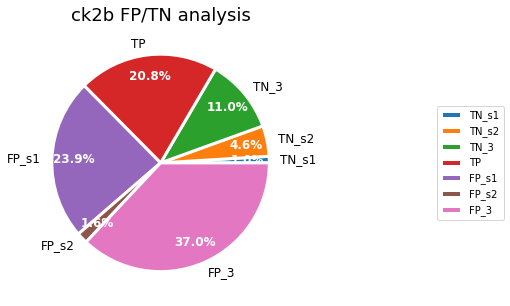

In [730]:
eval_ck2b  = add_ratio_cols("eval_metric_ck2b.txt")
pie_chart_list,labels = gen_pie_chart_list_all(eval_ck2b)
draw_pie_chart(pie_chart_list, labels,'ck2b')


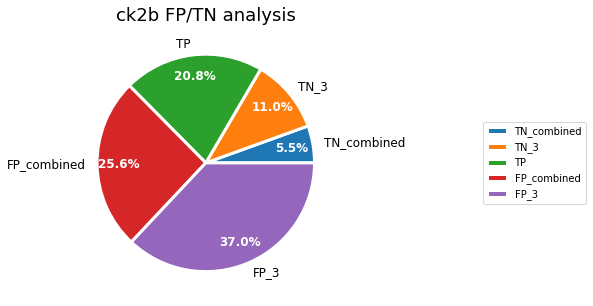

In [733]:
eval_ck2b  = add_ratio_cols("eval_metric_ck2b.txt")
pie_chart_list,labels = gen_pie_chart_list_combine(eval_ck2b)
draw_pie_chart(pie_chart_list, labels,'ck2b')



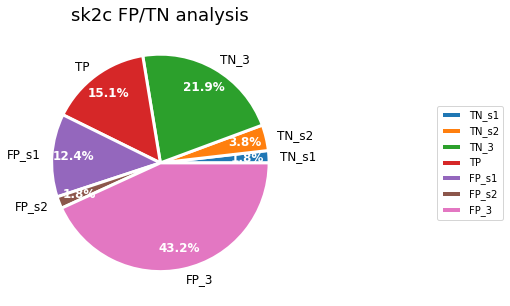

In [734]:
eval_ck2b  = add_ratio_cols("eval_metric_sk2c.csv")
pie_chart_list,labels = gen_pie_chart_list_all(eval_ck2b)
draw_pie_chart(pie_chart_list, labels,'sk2c')


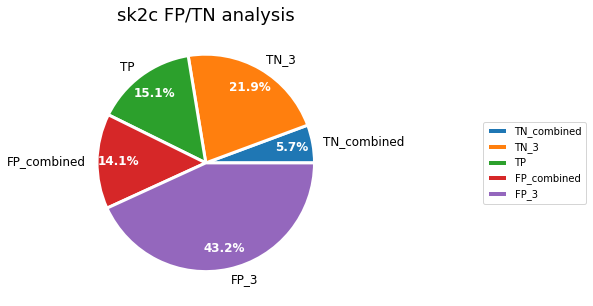

In [736]:
eval_ck2b  = add_ratio_cols("eval_metric_sk2c.csv")
pie_chart_list,labels = gen_pie_chart_list_combine(eval_ck2b)
draw_pie_chart(pie_chart_list, labels,'sk2c')

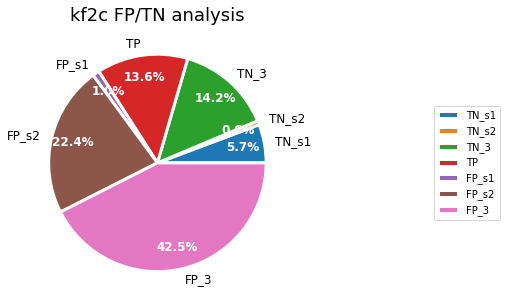

In [741]:
eval_ck2b  = add_ratio_cols("eval_metric_kf2c.csv")
pie_chart_list,labels = gen_pie_chart_list_all(eval_ck2b)
draw_pie_chart(pie_chart_list, labels,'kf2c')

# pie chart

In [706]:
import matplotlib.pyplot as plt
def draw_pie_chart(pie_chart_list, labels,title):
#labels =['TN_s1','TN_s2','TN_3','TP','FP_s1','FP_s2','FP_3']
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts =ax.pie(pie_chart_list,
            labels=labels,
            #radius=1.5,
            textprops={'color':'black',  'size':12},  # 設定文字樣式
            pctdistance=0.8,
            autopct=lambda i: f'{i:.1f}%' ,
            wedgeprops={'linewidth':3,'edgecolor':'w'})   # 繪製每個扇形的外框
    
    ax.legend(          
          loc="center left",
          bbox_to_anchor=(1.5, 0, 0.5, 1))
    plt.setp(autotexts, size=12,color='white', weight="bold")
    ax.set_title("{} FP/TN analysis".format(title),size=18)
    plt.show()

In [379]:
proposals_roih_c2b[0].get('scores')

tensor([0.9708, 0.9707, 0.9612, 0.9462, 0.9312, 0.8988, 0.8963, 0.8774, 0.8749,
        0.8527, 0.7561, 0.7531, 0.6275, 0.5939, 0.5390, 0.4565, 0.4178, 0.2566,
        0.1998, 0.1848, 0.1812, 0.1348, 0.1121, 0.0759, 0.0390, 0.0331, 0.0330,
        0.0310, 0.0206, 0.0180, 0.0171, 0.0161, 0.0135, 0.0127, 0.0123, 0.0106,
        0.0099, 0.0094], device='cuda:0')

In [382]:
len(proposals_roih_c2b[0].get('scores'))

38

In [353]:
proposals_roih_c2b[0].get('pred_boxes')[9]

Boxes(tensor([[1278.2928,   10.8888, 1280.4000,   71.5135]], device='cuda:0'))

In [408]:
def print_pred_box(proposals_roih):
    for proposal in proposals_roih:
        print(proposal.cpu().numpy())

In [310]:
len(proposals_roih_k2b[0].get('scores'))

51

## compute IoU

In [210]:
from detectron2 import structures 

In [211]:
box_list=[]
for ann in data_annotation[0]['annotations']:
    box_list.append(ann['bbox'])
    
box_list

[[206.0, 338.0, 283.0, 389.0],
 [47.0, 344.0, 131.0, 402.0],
 [247.0, 344.0, 348.0, 397.0],
 [0.0, 337.0, 53.0, 404.0],
 [684.0, 357.0, 722.0, 394.0],
 [706.0, 364.0, 735.0, 392.0],
 [727.0, 366.0, 762.0, 402.0],
 [749.0, 362.0, 810.0, 410.0],
 [787.0, 358.0, 907.0, 426.0],
 [880.0, 376.0, 961.0, 453.0],
 [936.0, 336.0, 1213.0, 485.0],
 [1204.0, 416.0, 1280.0, 531.0],
 [552.0, 356.0, 566.0, 369.0],
 [574.0, 352.0, 587.0, 370.0],
 [581.0, 357.0, 599.0, 379.0],
 [596.0, 352.0, 637.0, 387.0],
 [518.0, 356.0, 536.0, 369.0],
 [502.0, 357.0, 519.0, 372.0],
 [453.0, 353.0, 480.0, 374.0]]

In [212]:
bboxes_gt = structures.Boxes(torch.Tensor(box_list)).to("cuda")


### scaling

In [383]:
def scaling(proposal_roih):
    scale_pred = proposal_roih[0].get('pred_boxes')
    scale_pred.scale(1.2,1.2)
    return scale_pred

* c2b

In [388]:
c2b_prediction = scaling(proposals_roih_c2b)
len(c2b_prediction)

38

In [389]:
c2b_prediction[0]

Boxes(tensor([[ 932.3957,  338.5221, 1221.3375,  481.6961]], device='cuda:0'))

In [390]:
c2b_prediction[9]

Boxes(tensor([[1278.2928,   10.8888, 1280.4000,   71.5135]], device='cuda:0'))

* k2b

In [385]:
k2b_prediction = scaling(proposals_roih_k2b)
len(k2b_prediction)

51

In [459]:
k2b_prediction[22]

Boxes(tensor([[635.0712, 226.5593, 684.0731, 297.1222]], device='cuda:0'))

## pariwise

In [337]:
bboxes_gt

Boxes(tensor([[ 206.,  338.,  283.,  389.],
        [  47.,  344.,  131.,  402.],
        [ 247.,  344.,  348.,  397.],
        [   0.,  337.,   53.,  404.],
        [ 684.,  357.,  722.,  394.],
        [ 706.,  364.,  735.,  392.],
        [ 727.,  366.,  762.,  402.],
        [ 749.,  362.,  810.,  410.],
        [ 787.,  358.,  907.,  426.],
        [ 880.,  376.,  961.,  453.],
        [ 936.,  336., 1213.,  485.],
        [1204.,  416., 1280.,  531.],
        [ 552.,  356.,  566.,  369.],
        [ 574.,  352.,  587.,  370.],
        [ 581.,  357.,  599.,  379.],
        [ 596.,  352.,  637.,  387.],
        [ 518.,  356.,  536.,  369.],
        [ 502.,  357.,  519.,  372.],
        [ 453.,  353.,  480.,  374.]], device='cuda:0'))

In [792]:
pairwise_gt_c2b = structures.pairwise_iou(bboxes_gt,c2b_prediction)

In [448]:
pairwise_gt_k2b = structures.pairwise_iou(bboxes_gt,k2b_prediction)

In [395]:
pairwise_c2b_gt = structures.pairwise_iou(c2b_prediction,bboxes_gt)

In [396]:
pairwise_c2b_gt.size()

torch.Size([38, 19])

In [398]:
 pairwise_c2b_gt[0].get('scores')[8]

AttributeError: 'Tensor' object has no attribute 'get'

In [397]:
pairwise_c2b_gt[8]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0233, 0.6042, 0.2457, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:0')

In [419]:
pairwise_c2b_k2b = structures.pairwise_iou(c2b_prediction,k2b_prediction)

In [432]:
pairwise_k2b_c2b = structures.pairwise_iou(k2b_prediction,c2b_prediction)

### check if no match idx

In [535]:
def get_match_array(pairwise_iou_results):
    match_array=[None]*len(pairwise_iou_results)
    for i in range(len(pairwise_iou_results)):
        if torch.sum(pairwise_iou_results[i])==0:
            match_array[i] = False
            #print("{} no match index".format(i))
        else:
            match_array[i] = True
    return match_array
    

In [550]:
print(get_match_array(pairwise_gt_c2b))

[True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, False, True]


In [537]:
def check_match_idx(pairwise_iou_results):
    for i in range(len(pairwise_iou_results)):
        if torch.sum(pairwise_iou_results[i])==0:
            print("{} no match index".format(i))
    

In [449]:
check_match_idx(pairwise_gt_c2b)

12 no match index
16 no match index
17 no match index


In [450]:
check_match_idx(pairwise_gt_k2b)

12 no match index


In [458]:
check_match_idx(pairwise_c2b_k2b)

In [437]:
check_match_idx(pairwise_k2b_c2b)

22 no match index
31 no match index
35 no match index
43 no match index
45 no match index
46 no match index
48 no match index
49 no match index
50 no match index


In [452]:
check_match_idx(pairwise_c2b_gt)

9 no match index
20 no match index
24 no match index
25 no match index
26 no match index
29 no match index
30 no match index
36 no match index


In [453]:
check_match_idx(pairwise_k2b_gt)

14 no match index
17 no match index
18 no match index
19 no match index
20 no match index
22 no match index
28 no match index
29 no match index
30 no match index
31 no match index
35 no match index
41 no match index
45 no match index
46 no match index


In [412]:
proposals_roih_c2b[0].get('scores')

tensor([0.9708, 0.9707, 0.9612, 0.9462, 0.9312, 0.8988, 0.8963, 0.8774, 0.8749,
        0.8527, 0.7561, 0.7531, 0.6275, 0.5939, 0.5390, 0.4565, 0.4178, 0.2566,
        0.1998, 0.1848, 0.1812, 0.1348, 0.1121, 0.0759, 0.0390, 0.0331, 0.0330,
        0.0310, 0.0206, 0.0180, 0.0171, 0.0161, 0.0135, 0.0127, 0.0123, 0.0106,
        0.0099, 0.0094], device='cuda:0')

In [505]:
proposals_roih_k2b[0].get('pred_boxes')[33]

Boxes(tensor([[610.5521, 313.7825, 643.9567, 357.8959]], device='cuda:0'))

* print match result

In [426]:
def pair_match_idx(pairwise_iou_results):
    meet_gt_idx = torch.argmax(pairwise_iou_results,dim=1)
    return meet_gt_idx
    

In [517]:
pmi_gt_k2b = pair_match_idx(pairwise_gt_k2b)
pmi_gt_c2b = pair_match_idx(pairwise_gt_c2b)
pmi_c2b_gt = pair_match_idx(pairwise_c2b_gt)
pmi_k2b_gt = pair_match_idx(pairwise_k2b_gt)
pmi = pair_match_idx(pairwise_c2b_k2b)
pmi_51 = pair_match_idx(pairwise_k2b_c2b)

In [518]:
for idx in pmi_k2b_gt:
    print(idx.cpu().numpy())

8
10
7
1
15
6
4
9
2
3
0
5
11
18
0
0
2
0
0
0
0
2
0
14
4
14
10
11
0
0
0
0
10
15
10
0
2
18
18
10
18
0
18
17
18
0
0
17
16
16
16


In [434]:
def get_match_list(pmi):
# c2b 38  k2b 51  c2b->k2b
    match_list={}
    for i,pair_idx in enumerate(pmi.cpu().numpy()):
        if pair_idx in match_list:        
            match_list[pair_idx].append(i)
        else:
            match_list[pair_idx]= [i]

    return match_list

In [442]:
def print_match_list(match_list,proposal_len):
    for i in range(proposal_len):
        if i in match_list:   
            print("{}: {}".format(i,match_list[i]))
        else:
            print("{} no match idx".format(i))

In [446]:

print_match_list(get_match_list(pmi_51),len(proposals_roih_c2b[0].get('scores')))

0: [1, 22, 26, 31, 32, 35, 39, 43, 45, 46, 48, 49, 50]
1: [0]
2: [2]
3: [3]
4: [7]
5: [8]
6: [4, 33]
7: [9]
8: [5]
9: [28]
10: [6, 24]
11 no match idx
12 no match idx
13: [15]
14: [11]
15 no match idx
16: [12, 27]
17 no match idx
18: [23]
19 no match idx
20: [18]
21: [25]
22 no match idx
23 no match idx
24: [14, 20, 30]
25: [34]
26: [19, 29]
27 no match idx
28 no match idx
29: [41]
30 no match idx
31: [16, 36]
32: [13, 37, 40, 42, 44, 47]
33 no match idx
34: [10, 21]
35: [38]
36: [17]
37 no match idx


In [444]:
print_match_list(get_match_list(pmi),len(proposals_roih_k2b[0].get('scores')))

0: [1]
1: [0]
2: [2]
3: [3, 17]
4: [6, 19]
5: [8]
6: [10, 15, 27]
7: [4]
8: [5, 23]
9: [7, 11, 22]
10: [12, 37]
11: [14, 28]
12: [16]
13: [32]
14 no match idx
15: [13, 33]
16: [31]
17: [36]
18: [20, 25]
19: [26, 30]
20: [24]
21: [34]
22 no match idx
23: [18]
24 no match idx
25: [21]
26 no match idx
27 no match idx
28: [9]
29 no match idx
30 no match idx
31 no match idx
32 no match idx
33 no match idx
34 no match idx
35 no match idx
36 no match idx
37 no match idx
38: [35]
39 no match idx
40 no match idx
41: [29]
42 no match idx
43 no match idx
44 no match idx
45 no match idx
46 no match idx
47 no match idx
48 no match idx
49 no match idx
50 no match idx


In [414]:
from detectron2.structures.boxes import pairwise_intersection
xx = pairwise_intersection(proposals_roih_c2b[0].get('pred_boxes'),bboxes_gt)


## filter

In [174]:
instances = proposals_roih_c2b[0]
confident_detections = instances[instances.scores > 0]


In [175]:
len(confident_detections.pred_boxes)

38

In [202]:
confident_detections.scores

tensor([0.9708, 0.9707, 0.9612, 0.9462, 0.9312, 0.8988, 0.8963, 0.8774, 0.8749,
        0.8527, 0.7561, 0.7531, 0.6275, 0.5939, 0.5390, 0.4565, 0.4178, 0.2566,
        0.1998, 0.1848, 0.1812, 0.1348, 0.1121, 0.0759, 0.0390, 0.0331, 0.0330,
        0.0310, 0.0206, 0.0180, 0.0171, 0.0161, 0.0135, 0.0127, 0.0123, 0.0106,
        0.0099, 0.0094], device='cuda:0')

In [176]:
c2b_th9_box = confident_detections.pred_boxes

In [177]:
c2b_th9_box

Boxes(tensor([[7.7700e+02, 2.8210e+02, 1.0178e+03, 4.0141e+02],
        [6.6268e+02, 3.0204e+02, 7.5483e+02, 3.5835e+02],
        [6.2529e+02, 3.0214e+02, 6.8357e+02, 3.4421e+02],
        [3.2344e+01, 2.9166e+02, 1.0653e+02, 3.3348e+02],
        [7.3465e+02, 3.1425e+02, 8.0589e+02, 3.7391e+02],
        [2.0518e+02, 2.9081e+02, 2.9127e+02, 3.3141e+02],
        [4.9912e+02, 2.9502e+02, 5.2996e+02, 3.2110e+02],
        [0.0000e+00, 2.8366e+02, 4.8641e+01, 3.3591e+02],
        [6.1080e+02, 3.0543e+02, 6.4328e+02, 3.3699e+02],
        [1.0652e+03, 9.0740e+00, 1.0670e+03, 5.9595e+01],
        [5.6943e+02, 2.9957e+02, 5.9874e+02, 3.2588e+02],
        [0.0000e+00, 2.7891e+02, 8.9758e+00, 3.2653e+02],
        [1.6999e+02, 2.8603e+02, 2.1518e+02, 3.2170e+02],
        [1.7902e+02, 2.9899e+02, 2.5009e+02, 3.7980e+02],
        [5.9046e+02, 3.0378e+02, 6.1983e+02, 3.3165e+02],
        [5.7619e+02, 3.0080e+02, 6.1450e+02, 3.2935e+02],
        [1.0031e+03, 3.4803e+02, 1.0663e+03, 4.3679e+02],
        

In [178]:
c2b_th9_box.scale(1.2,1.2)

In [179]:
c2b_th9_box

Boxes(tensor([[9.3240e+02, 3.3852e+02, 1.2213e+03, 4.8170e+02],
        [7.9522e+02, 3.6244e+02, 9.0580e+02, 4.3002e+02],
        [7.5035e+02, 3.6257e+02, 8.2029e+02, 4.1306e+02],
        [3.8813e+01, 3.4999e+02, 1.2784e+02, 4.0018e+02],
        [8.8157e+02, 3.7710e+02, 9.6706e+02, 4.4869e+02],
        [2.4622e+02, 3.4897e+02, 3.4952e+02, 3.9769e+02],
        [5.9895e+02, 3.5402e+02, 6.3595e+02, 3.8532e+02],
        [0.0000e+00, 3.4040e+02, 5.8369e+01, 4.0309e+02],
        [7.3296e+02, 3.6651e+02, 7.7193e+02, 4.0439e+02],
        [1.2783e+03, 1.0889e+01, 1.2804e+03, 7.1514e+01],
        [6.8331e+02, 3.5948e+02, 7.1848e+02, 3.9106e+02],
        [0.0000e+00, 3.3469e+02, 1.0771e+01, 3.9184e+02],
        [2.0399e+02, 3.4324e+02, 2.5822e+02, 3.8604e+02],
        [2.1483e+02, 3.5879e+02, 3.0010e+02, 4.5576e+02],
        [7.0855e+02, 3.6453e+02, 7.4380e+02, 3.9798e+02],
        [6.9143e+02, 3.6096e+02, 7.3740e+02, 3.9521e+02],
        [1.2037e+03, 4.1763e+02, 1.2796e+03, 5.2414e+02],
        

# visualizer

In [795]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
import cv2

In [796]:
target_metadata = MetadataCatalog.get(dataset_name)

In [797]:
im = cv2.imread(test_data[0]['file_name'], cv2.IMREAD_COLOR)[:, :, ::-1]

In [800]:
bboxes_gt

Boxes(tensor([[ 206.,  338.,  283.,  389.],
        [  47.,  344.,  131.,  402.],
        [ 247.,  344.,  348.,  397.],
        [   0.,  337.,   53.,  404.],
        [ 684.,  357.,  722.,  394.],
        [ 706.,  364.,  735.,  392.],
        [ 727.,  366.,  762.,  402.],
        [ 749.,  362.,  810.,  410.],
        [ 787.,  358.,  907.,  426.],
        [ 880.,  376.,  961.,  453.],
        [ 936.,  336., 1213.,  485.],
        [1204.,  416., 1280.,  531.],
        [ 552.,  356.,  566.,  369.],
        [ 574.,  352.,  587.,  370.],
        [ 581.,  357.,  599.,  379.],
        [ 596.,  352.,  637.,  387.],
        [ 518.,  356.,  536.,  369.],
        [ 502.,  357.,  519.,  372.],
        [ 453.,  353.,  480.,  374.]], device='cuda:0'))

In [801]:
bboxes_gt = bboxes_gt[[0,1,2,3,9,10,11],:]

In [802]:
v = Visualizer(
        im[:, :, ::-1], 
        metadata=target_metadata, 
        scale=1,
        )
for i,box in enumerate(c2b_th9_box.to('cpu')):
    v.draw_box(box,edge_color='r')    
    #score = confident_detections.scores[i].cpu()    
    #v.draw_text(str(score.numpy()),tuple([score.numpy(),score.numpy()]),color='r')
for box in bboxes_gt.to('cpu'):
    v.draw_box(box,edge_color='b')
    #v.draw_text(str(box[:2].numpy()), tuple(box[:2].numpy()),color='b')

v = v.get_output()
img =  v.get_image()[:, :, ::-1]


In [803]:
cv2.imwrite('showbb.jpg', img)

True

### draw specific bbox

In [488]:
from detectron2.structures.boxes import Boxes
#k2b fp1
#new_boxes = k2b_prediction[[22,31,35,45,46],:]

new_boxes = c2b_prediction[[9,20,24,25,26,29,30,36],:]
new_boxes2 = k2b_prediction[[14,17,18,19,20,28,29,30,41],:]

#new_boxes

In [493]:
new_boxes = bboxes_gt[[16,17],:]
new_boxes2 = bboxes_gt[[12],:]

In [527]:
print(proposals_roih_k2b[0].get('scores')[48])
print(proposals_roih_k2b[0].get('scores')[43])

new_boxes = bboxes_gt[[16,17],:]
new_boxes2 = k2b_prediction[[43,48,49,50],:]

tensor(0.0043, device='cuda:0')
tensor(0.0088, device='cuda:0')


In [528]:
im = cv2.imread(test_data[0]['file_name'], cv2.IMREAD_COLOR)[:, :, ::-1]
v = Visualizer(
        im[:, :, ::-1], 
        metadata=target_metadata, 
        scale=1,
        )
for box in new_boxes.to('cpu'):
    #print(box)
    v.draw_box(box,edge_color='r')    
for box in new_boxes2.to('cpu'):
    #print(box)
    v.draw_box(box,edge_color='g')    
    
v = v.get_output()
img =  v.get_image()[:, :, ::-1]    
cv2.imwrite('showbb.jpg', img)

True

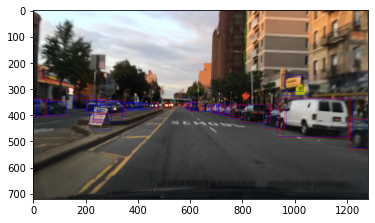

In [270]:
from matplotlib import pyplot as plt

#Show the image with matplotlib
plt.imshow(img)
plt.show()

In [ ]:
def score_filter(proposals, th):
    score_list = proposals.get('scores')
    bbox_list= proposals.get('pred_boxes')
    new_proposals =[]
    for i in range(len(proposals)):
        

        score = proposals[i]
        if score>th:
            proposals
            print(score)

In [57]:
score_filter(proposals_roih_c2b[0],0.5)

tensor(0.9860, device='cuda:0')
tensor(0.9813, device='cuda:0')
tensor(0.9627, device='cuda:0')
tensor(0.9480, device='cuda:0')
tensor(0.9304, device='cuda:0')
tensor(0.9262, device='cuda:0')
tensor(0.8904, device='cuda:0')
tensor(0.8686, device='cuda:0')
tensor(0.8171, device='cuda:0')
tensor(0.7935, device='cuda:0')
tensor(0.6872, device='cuda:0')


IndexError: index 26 is out of bounds for dimension 0 with size 26

In [24]:
for i in range(100):
    data = next(data_loader_iter_obj)
    label_data_q, label_data_k, unlabel_data_q, unlabel_data_k = data
    with torch.no_grad():
        (_,  proposals_rpn_unsup_k, proposals_roih_unsup_k, _,) =model_c2b.modelStudent(
            unlabel_data_k, branch="unsup_data_weak")

        score_filter(proposals_roih_unsup_k,0.5)


tensor(0.6534, device='cuda:0')


IndexError: index 15 is out of bounds for dimension 0 with size 15

In [ ]:
# 100
#'pred_boxes' 
'scores'
'pred_classes'
'scores_logists'
'boxes_sigma'

In [19]:
proposals_roih_unsup_k[0].get('scores')

tensor([0.9838, 0.9832, 0.9797, 0.9756, 0.9673, 0.8527, 0.8314, 0.8230, 0.3675,
        0.2064, 0.1819, 0.1548, 0.1441, 0.0712, 0.0578, 0.0454, 0.0381, 0.0380,
        0.0380, 0.0349, 0.0281, 0.0250, 0.0185, 0.0173, 0.0163, 0.0140, 0.0133,
        0.0114, 0.0108, 0.0086, 0.0075, 0.0067, 0.0064, 0.0063],
       device='cuda:0')

In [105]:

#for proposal_bbox_inst in proposals_roih_unsup_k:
pesudo_proposals_roih_unsup_k = threshold_bbox(proposals_roih_unsup_k[0], 0.8, "roih")
    
            

In [106]:
pesudo_proposals_roih_unsup_k

FreeInstances(num_instances=0, image_height=600, image_width=1200, fields=[pseudo_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores_logists: tensor([], device='cuda:0', size=(0, 2)), boxes_sigma: tensor([], device='cuda:0', size=(0, 4))])

In [101]:
from pt.structures.instances import FreeInstances
from detectron2.structures.boxes import Boxes

def threshold_bbox(proposal_bbox_inst, thres=0.7, proposal_type="roih"):
    valid_map = proposal_bbox_inst.scores > thres
    # ------------ >all -----------
    # create instances containing boxes and gt_classes
    image_shape = proposal_bbox_inst.image_size
    new_proposal_inst = FreeInstances(image_shape)

    # ------------ <all -----------
    # adapteacher threshold valid_map
    new_bbox_loc = proposal_bbox_inst.pred_boxes.tensor[valid_map, :]
    pseudo_boxes = Boxes(new_bbox_loc)

    # add boxes to instances
    new_proposal_inst.pseudo_boxes = pseudo_boxes
    # adapteacher threshold valid_map
    new_proposal_inst.scores_logists = proposal_bbox_inst.scores_logists[valid_map]
    if proposal_bbox_inst.has('boxes_sigma'):
        new_proposal_inst.boxes_sigma = proposal_bbox_inst.boxes_sigma[valid_map]
    return new_proposal_inst

# Avg

In [113]:
def avgWeight(model_list,ratio_list):
    parties = len(model_list)
    model_tmp=[None] * parties
    #optims_tmp=[None] * parties

    for idx, my_model in enumerate(model_list):
        
        model_tmp[idx] = my_model.state_dict()


    for key in model_tmp[0]:    
        print(key)
        model_avg = 0

        for idx, model_tmp_content in enumerate(model_tmp):     # add each model              
            model_avg += ratio_list[idx] * model_tmp_content[key]
            
        for i in range(len(model_tmp)):  #copy to each model            
            model_tmp[i][key] = model_avg
    for i in range(len(model_list)):    
        model_list[i].load_state_dict(model_tmp[i])
        
    return model_list  #, optims_tmp
    

In [114]:
def avg_model_weight(model_list):
    balance = 1/len(model_list)
    ratio_list= [balance] * len(model_list)
    
    avg_model=avgWeight(model_list,ratio_list)
    return avg_model


In [116]:
mGPUs=False
avg_model = avg_model_weight(model_list_ck2b)



backbone.vgg_block1.0.conv1.weight
backbone.vgg_block1.0.conv1.bias
backbone.vgg_block1.0.conv2.weight
backbone.vgg_block1.0.conv2.bias
backbone.vgg_block2.0.conv1.weight
backbone.vgg_block2.0.conv1.bias
backbone.vgg_block2.0.conv2.weight
backbone.vgg_block2.0.conv2.bias
backbone.vgg_block3.0.conv1.weight
backbone.vgg_block3.0.conv1.bias
backbone.vgg_block3.0.conv2.weight
backbone.vgg_block3.0.conv2.bias
backbone.vgg_block3.0.conv3.weight
backbone.vgg_block3.0.conv3.bias
backbone.vgg_block4.0.conv1.weight
backbone.vgg_block4.0.conv1.bias
backbone.vgg_block4.0.conv2.weight
backbone.vgg_block4.0.conv2.bias
backbone.vgg_block4.0.conv3.weight
backbone.vgg_block4.0.conv3.bias
backbone.vgg_block5.0.conv1.weight
backbone.vgg_block5.0.conv1.bias
backbone.vgg_block5.0.conv2.weight
backbone.vgg_block5.0.conv2.bias
backbone.vgg_block5.0.conv3.weight
backbone.vgg_block5.0.conv3.bias
proposal_generator.rpn_head.conv.weight
proposal_generator.rpn_head.conv.bias
proposal_generator.rpn_head.objectness

In [ ]:
output_dir = 'models/avg_ck2b'
save_name = os.path.join(output_dir, 'pt_ck2b_AVG.pth')
torch.save(avg_model[0].state_dict(), save_name)

In [ ]:
checkpointer = DetectionCheckpointer(trainer.model, save_dir=cfg.OUTPUT_DIR)

In [ ]:
from pt.engine.trainer import PTrainer
from detectron2.checkpoint import DetectionCheckpointer

cfg = setup("configs/pt/k2bdd.yaml")
cfg.defrost()
cfg.MODEL.WEIGHTS = "keep_experiments/k2b/model_final.pth"
model = PTrainer.build_model(cfg)
DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
                cfg.MODEL.WEIGHTS, resume=False
            )
res = PTrainer.test(cfg, model)

In [101]:
c2bmodel= torch.load("keep_experiments/c2b/model_0011999.pth")

In [77]:
k2bmodel = torch.load("keep_experiments/k2b/model_final.pth")


In [99]:
k2bmodel.keys()

dict_keys(['model', 'optimizer', 'scheduler', 'iteration'])

In [100]:
k2bmodel['model'].keys()

odict_keys(['modelTeacher.backbone.vgg_block1.0.conv1.weight', 'modelTeacher.backbone.vgg_block1.0.conv1.bias', 'modelTeacher.backbone.vgg_block1.0.conv2.weight', 'modelTeacher.backbone.vgg_block1.0.conv2.bias', 'modelTeacher.backbone.vgg_block2.0.conv1.weight', 'modelTeacher.backbone.vgg_block2.0.conv1.bias', 'modelTeacher.backbone.vgg_block2.0.conv2.weight', 'modelTeacher.backbone.vgg_block2.0.conv2.bias', 'modelTeacher.backbone.vgg_block3.0.conv1.weight', 'modelTeacher.backbone.vgg_block3.0.conv1.bias', 'modelTeacher.backbone.vgg_block3.0.conv2.weight', 'modelTeacher.backbone.vgg_block3.0.conv2.bias', 'modelTeacher.backbone.vgg_block3.0.conv3.weight', 'modelTeacher.backbone.vgg_block3.0.conv3.bias', 'modelTeacher.backbone.vgg_block4.0.conv1.weight', 'modelTeacher.backbone.vgg_block4.0.conv1.bias', 'modelTeacher.backbone.vgg_block4.0.conv2.weight', 'modelTeacher.backbone.vgg_block4.0.conv2.bias', 'modelTeacher.backbone.vgg_block4.0.conv3.weight', 'modelTeacher.backbone.vgg_block4.0.c

In [96]:
avg_bdd_model = torch.load("models/avg_ck2b/pt_ck2b_AVG.pth")


In [109]:
model_list_loadbdd = [c2bmodel,k2bmodel]
avg_bdd_model_v2 = avg_model_weight(model_list_loadbdd)

AttributeError: 'collections.OrderedDict' object has no attribute 'load_state_dict'

In [98]:
avg_bdd_model.keys()

odict_keys(['backbone.vgg_block1.0.conv1.weight', 'backbone.vgg_block1.0.conv1.bias', 'backbone.vgg_block1.0.conv2.weight', 'backbone.vgg_block1.0.conv2.bias', 'backbone.vgg_block2.0.conv1.weight', 'backbone.vgg_block2.0.conv1.bias', 'backbone.vgg_block2.0.conv2.weight', 'backbone.vgg_block2.0.conv2.bias', 'backbone.vgg_block3.0.conv1.weight', 'backbone.vgg_block3.0.conv1.bias', 'backbone.vgg_block3.0.conv2.weight', 'backbone.vgg_block3.0.conv2.bias', 'backbone.vgg_block3.0.conv3.weight', 'backbone.vgg_block3.0.conv3.bias', 'backbone.vgg_block4.0.conv1.weight', 'backbone.vgg_block4.0.conv1.bias', 'backbone.vgg_block4.0.conv2.weight', 'backbone.vgg_block4.0.conv2.bias', 'backbone.vgg_block4.0.conv3.weight', 'backbone.vgg_block4.0.conv3.bias', 'backbone.vgg_block5.0.conv1.weight', 'backbone.vgg_block5.0.conv1.bias', 'backbone.vgg_block5.0.conv2.weight', 'backbone.vgg_block5.0.conv2.bias', 'backbone.vgg_block5.0.conv3.weight', 'backbone.vgg_block5.0.conv3.bias', 'proposal_generator.rpn_he

In [91]:
model_k2b.state_dict().keys()

odict_keys(['backbone.vgg_block1.0.conv1.weight', 'backbone.vgg_block1.0.conv1.bias', 'backbone.vgg_block1.0.conv2.weight', 'backbone.vgg_block1.0.conv2.bias', 'backbone.vgg_block2.0.conv1.weight', 'backbone.vgg_block2.0.conv1.bias', 'backbone.vgg_block2.0.conv2.weight', 'backbone.vgg_block2.0.conv2.bias', 'backbone.vgg_block3.0.conv1.weight', 'backbone.vgg_block3.0.conv1.bias', 'backbone.vgg_block3.0.conv2.weight', 'backbone.vgg_block3.0.conv2.bias', 'backbone.vgg_block3.0.conv3.weight', 'backbone.vgg_block3.0.conv3.bias', 'backbone.vgg_block4.0.conv1.weight', 'backbone.vgg_block4.0.conv1.bias', 'backbone.vgg_block4.0.conv2.weight', 'backbone.vgg_block4.0.conv2.bias', 'backbone.vgg_block4.0.conv3.weight', 'backbone.vgg_block4.0.conv3.bias', 'backbone.vgg_block5.0.conv1.weight', 'backbone.vgg_block5.0.conv1.bias', 'backbone.vgg_block5.0.conv2.weight', 'backbone.vgg_block5.0.conv2.bias', 'backbone.vgg_block5.0.conv3.weight', 'backbone.vgg_block5.0.conv3.bias', 'proposal_generator.rpn_he

In [95]:
k2bmodel['.state_dict()']

AttributeError: 'dict' object has no attribute 'state_dict'

In [83]:
model_keys = sorted(k2bmodel['model'].keys())
model_keys

['modelStudent.backbone.vgg_block1.0.conv1.bias',
 'modelStudent.backbone.vgg_block1.0.conv1.weight',
 'modelStudent.backbone.vgg_block1.0.conv2.bias',
 'modelStudent.backbone.vgg_block1.0.conv2.weight',
 'modelStudent.backbone.vgg_block2.0.conv1.bias',
 'modelStudent.backbone.vgg_block2.0.conv1.weight',
 'modelStudent.backbone.vgg_block2.0.conv2.bias',
 'modelStudent.backbone.vgg_block2.0.conv2.weight',
 'modelStudent.backbone.vgg_block3.0.conv1.bias',
 'modelStudent.backbone.vgg_block3.0.conv1.weight',
 'modelStudent.backbone.vgg_block3.0.conv2.bias',
 'modelStudent.backbone.vgg_block3.0.conv2.weight',
 'modelStudent.backbone.vgg_block3.0.conv3.bias',
 'modelStudent.backbone.vgg_block3.0.conv3.weight',
 'modelStudent.backbone.vgg_block4.0.conv1.bias',
 'modelStudent.backbone.vgg_block4.0.conv1.weight',
 'modelStudent.backbone.vgg_block4.0.conv2.bias',
 'modelStudent.backbone.vgg_block4.0.conv2.weight',
 'modelStudent.backbone.vgg_block4.0.conv3.bias',
 'modelStudent.backbone.vgg_bloc

In [88]:
model_keys = sorted(model.state_dict().keys())
model_keys

['backbone.vgg_block1.0.conv1.bias',
 'backbone.vgg_block1.0.conv1.weight',
 'backbone.vgg_block1.0.conv2.bias',
 'backbone.vgg_block1.0.conv2.weight',
 'backbone.vgg_block2.0.conv1.bias',
 'backbone.vgg_block2.0.conv1.weight',
 'backbone.vgg_block2.0.conv2.bias',
 'backbone.vgg_block2.0.conv2.weight',
 'backbone.vgg_block3.0.conv1.bias',
 'backbone.vgg_block3.0.conv1.weight',
 'backbone.vgg_block3.0.conv2.bias',
 'backbone.vgg_block3.0.conv2.weight',
 'backbone.vgg_block3.0.conv3.bias',
 'backbone.vgg_block3.0.conv3.weight',
 'backbone.vgg_block4.0.conv1.bias',
 'backbone.vgg_block4.0.conv1.weight',
 'backbone.vgg_block4.0.conv2.bias',
 'backbone.vgg_block4.0.conv2.weight',
 'backbone.vgg_block4.0.conv3.bias',
 'backbone.vgg_block4.0.conv3.weight',
 'backbone.vgg_block5.0.conv1.bias',
 'backbone.vgg_block5.0.conv1.weight',
 'backbone.vgg_block5.0.conv2.bias',
 'backbone.vgg_block5.0.conv2.weight',
 'backbone.vgg_block5.0.conv3.bias',
 'backbone.vgg_block5.0.conv3.weight',
 'proposal_g

In [69]:
model_keys = sorted(model_c2b.state_dict().keys())
model_keys

['backbone.vgg_block1.0.conv1.bias',
 'backbone.vgg_block1.0.conv1.weight',
 'backbone.vgg_block1.0.conv2.bias',
 'backbone.vgg_block1.0.conv2.weight',
 'backbone.vgg_block2.0.conv1.bias',
 'backbone.vgg_block2.0.conv1.weight',
 'backbone.vgg_block2.0.conv2.bias',
 'backbone.vgg_block2.0.conv2.weight',
 'backbone.vgg_block3.0.conv1.bias',
 'backbone.vgg_block3.0.conv1.weight',
 'backbone.vgg_block3.0.conv2.bias',
 'backbone.vgg_block3.0.conv2.weight',
 'backbone.vgg_block3.0.conv3.bias',
 'backbone.vgg_block3.0.conv3.weight',
 'backbone.vgg_block4.0.conv1.bias',
 'backbone.vgg_block4.0.conv1.weight',
 'backbone.vgg_block4.0.conv2.bias',
 'backbone.vgg_block4.0.conv2.weight',
 'backbone.vgg_block4.0.conv3.bias',
 'backbone.vgg_block4.0.conv3.weight',
 'backbone.vgg_block5.0.conv1.bias',
 'backbone.vgg_block5.0.conv1.weight',
 'backbone.vgg_block5.0.conv2.bias',
 'backbone.vgg_block5.0.conv2.weight',
 'backbone.vgg_block5.0.conv3.bias',
 'backbone.vgg_block5.0.conv3.weight',
 'proposal_g

In [ ]:
from detectron2.checkpoint.c2_model_loading import align_and_update_state_dicts

## evaluation (defaults.test)

In [16]:
#results = OrderedDict()
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import PascalVOCDetectionEvaluator
from detectron2.evaluation import inference_on_dataset

dataset_name = 'VOC2007_cityval'
test_data_loader = build_detection_test_loader(cfg2, dataset_name)
evaluator = PascalVOCDetectionEvaluator(dataset_name)




NOTE! Installing ujson may make loading annotations faster.


In [19]:
model_teacher2.eval()
results_i = inference_on_dataset(model_teacher1, test_data_loader, evaluator)


In [18]:
results_i

OrderedDict([('bbox',
              {'AP': 0.0001368769368142992,
               'AP50': 0.0004990887084364157,
               'AP75': 1.2379902565214852e-05})])

In [ ]:
for idx, inputs in enumerate(test_data_loader):

    outputs = model_teacher(inputs)
    evaluator.process(inputs, outputs)
results = evaluator.evaluate()

## visualization json metrics

In [10]:
import json

inputfile = 'output/k2c/metrics.json'

file1 = open(inputfile, 'r')

  
data=[]
for line in file1:    
    #print(" {}".format(line.strip()))
    data.append(json.loads(line))


In [6]:
len(data)

3035

In [7]:
data[3034]

{'data_time': 0.9129995629191399,
 'eta_seconds': 113084.55374613404,
 'iteration': 639,
 'loss_box_reg_unsup': 1.1091954708099365,
 'loss_cls_unsup': 0.00436224602162838,
 'loss_rpn_cls_unsup': 0.01346597634255886,
 'loss_rpn_loc_unsup': 0.39616869390010834,
 'lr': 0.001,
 'roi_head/num_target_bg_samples_unsupervised': 0.0,
 'roi_head/num_target_fg_samples_unsupervised': 0.0,
 'time': 3.762773280031979,
 'total_loss': 1.5815560518531129}

In [8]:
data[0]

{'data_time': 1.0406247302889824,
 'eta_seconds': 122627.56421338767,
 'iteration': 19,
 'loss_box_reg_unsup': 1.1284323334693909,
 'loss_cls_unsup': 0.1518690437078476,
 'loss_rpn_cls_unsup': 0.15071675926446915,
 'loss_rpn_loc_unsup': 0.7780852317810059,
 'lr': 0.0007752400000000001,
 'roi_head/num_target_bg_samples_unsupervised': 0.0,
 'roi_head/num_target_fg_samples_unsupervised': 0.0,
 'time': 4.090312348678708,
 'total_loss': 2.23546239733696}